## 사전 준비

In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# 기본 path
# /content/drive/Shared drives/[GH x RiderDash]/

In [ ]:
# 필요한 package
import itertools
import pandas as pd
import numpy as np
import pickle
import warnings 
from numpy import nan
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from gensim.models import Word2Vec
from tqdm import tqdm

plt.rcParams['figure.figsize'] = [10, 6]

warnings.filterwarnings('ignore')

In [ ]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/Shared drives/[GH x RiderDash]/Data/Preprocessing/total_df_store_add.csv',encoding='CP949', index_col=0)
product = pd.read_csv('/content/drive/Shared drives/[GH x RiderDash]/Data/raw_data/product.csv', index_col=0)
cars = pd.read_csv('/content/drive/Shared drives/[GH x RiderDash]/Data/Preprocessing/all_cars(modified).csv', index_col=0)
cars_info = pd.read_csv('/content/drive/Shared drives/[GH x RiderDash]/Data/Preprocessing/cars_info.csv', index_col=0)
store = pd.read_csv('/content/drive/Shared drives/[GH x RiderDash]/Data/Preprocessing/store_classification.csv', index_col=0)

## top N번째 store의 사용 제품 빈도를 통한 메이커별 유사도 측정

In [ ]:
# top N번째 시공점에서 각각의 경우에 대해 사용한 제품 메이커들 추출

N = 10 # 자연수
topN = store.sort_values(by="works", ascending=False)[(N-1):N]
for s in range(len(topN)):
    store_code = list(topN.iloc[[s]]['store'])[0]
    top1_store = df[df['store']==store_code]
    comb = []
    for i in range(len(top1_store)):
        tab = top1_store.iloc[[i]]
        index = list(tab.index)[0]
        items = [tab.loc[index,'product_1'],tab.loc[index,'product_2'],tab.loc[index,'product_3'],tab.loc[index,'product_4'],tab.loc[index,'product_5'],tab.loc[index,'product_6']]
        #item = [x for x in items if x is not np.nan]
        comb.append(items)
    whole = []
    for item_list in comb:
        real = []
        for j in item_list:
            if np.isnan(j):
                continue
            else:
                real.append(product.loc[j,'name'])
        whole.append(list(set(real)))
    
corpus = whole

# nan 값들 제거 작업
for i in range(len(corpus)):
    if nan in corpus[i]:
        corpus[i] = corpus[i].remove(nan)

corpus = [x for x in corpus if x!=None]

In [ ]:
# Word2Vec의 경우 (성능이 그렇게 좋아보이진 않았음)
# model = Word2Vec(corpus,min_count=1,size=300,window=5,workers=1)

In [ ]:
pip install glove_python

In [ ]:
from glove import Corpus, Glove

cor = Corpus()
cor.fit(corpus, window=1)

glove = Glove(no_components=40, learning_rate=0.05)
glove.fit(cor.matrix, epochs=50, no_threads=4, verbose=False)
glove.add_dictionary(cor.dictionary)
vocabs = glove.dictionary.keys()
word_vectors_list = [glove.word_vectors[glove.dictionary[v]] for v in vocabs]

In [ ]:
# 비슷한 메이커 보기
print(glove.most_similar("Vertex 700",number=3))

[('Vertex 500', 0.9995733839529004), ('Vertex 600', 0.9940624154781473)]


[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 15 samples in 0.000s...
[t-SNE] Computed neighbors for 15 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 15 / 15
[t-SNE] Mean sigma: 0.043812
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.983932
[t-SNE] KL divergence after 1000 iterations: 0.081974


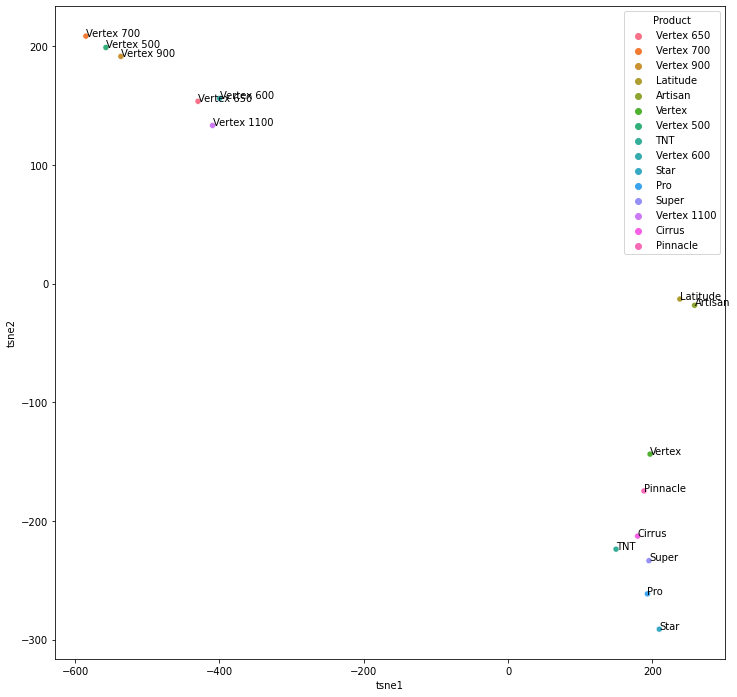

In [ ]:
# tsne
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=2, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(word_vectors_list)

# pca 파트
#tsne_results = tsne.fit_transform(PCA(n_components=10).fit_transform(word_vectors_list))

result = pd.DataFrame({'Product': list(vocabs), 'tsne1': tsne_results[:,0], 'tsne2': tsne_results[:,1]})


plt.figure(figsize=(12,12))
ax = sns.scatterplot(x="tsne1", y="tsne2", data=result, hue='Product')
for i, point in result.iterrows():
    ax.text(point['tsne1']+.02, point['tsne2'], str(point['Product']))
plt.show()

In [ ]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(word_vectors_list)
result = pd.DataFrame({'Product': list(glove.dictionary.keys()), 'pca1': printcipalComponents[:,0], 'pca2': printcipalComponents[:,1]})
pca.explained_variance_ratio_  # 누적 설명력 분산

array([0.65713177, 0.33747392])

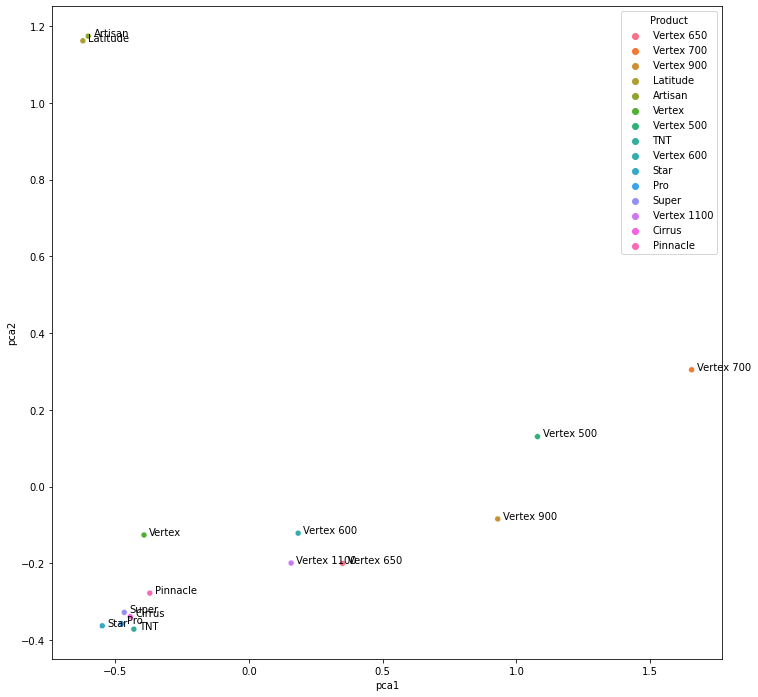

In [ ]:
plt.figure(figsize=(12,12))
ax = sns.scatterplot(x="pca1", y="pca2", data=result, hue='Product')
for i, point in result.iterrows():
    ax.text(point['pca1']+.02, point['pca2'], str(point['Product']))
plt.show()

## 전체 보증서 데이터에서 사용 제품 빈도를 통한 메이커별 유사도 측정

In [ ]:
# 전체 보증서 데이터에서 각 경우에 대해 사용한 제품 메이커 추출
#whole = []
#for s in tqdm(range(len(df))):
#    tab = df.loc[[s]]
#    items = [tab.loc[s,'product_1'],tab.loc[s,'product_2'],tab.loc[s,'product_3'],tab.loc[s,'product_4'],tab.loc[s,'product_5'],tab.loc[s,'product_6']]
#    #item = [x for x in items if x is not np.nan]
#    real = []
#    for j in items:
#        if np.isnan(j):
#            continue
#        else:
#            real.append(product.loc[j,'name'])
#    whole.append(list(set(real)))
    
#corpus = whole
#for i in range(len(corpus)):
#    if nan in corpus[i]:
#        corpus[i] = corpus[i].remove(nan)

100%|██████████| 395889/395889 [06:01<00:00, 1095.81it/s]


In [ ]:
# None 값 제거
# corpus = [x for x in corpus if x!=None]
# len(corpus)

In [ ]:
# corpus 파일 저장
#import pickle
#with open('/content/drive/Shared drives/[GH x RiderDash]/Data/temporary/corpus.pickle', 'wb') as f:
#    pickle.dump(corpus, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# corpus 파일 불러오기
import pickle
with open('/content/drive/Shared drives/[GH x RiderDash]/Data/temporary/corpus.pickle', 'rb') as fr:
    corpus = pickle.load(fr)

In [ ]:
# Word2Vec 사용 (성능이 그렇게 좋아보이진 않음)
#model = Word2Vec(corpus,min_count=1,size=100,window=1,workers=4,sg=1)

In [ ]:
pip install glove_python

In [ ]:
from glove import Corpus, Glove

cor = Corpus()
cor.fit(corpus, window=1)

glove = Glove(no_components=40, learning_rate=0.05)
glove.fit(cor.matrix, epochs=40, no_threads=4, verbose=False)
glove.add_dictionary(cor.dictionary)

In [ ]:
print(glove.most_similar("Vertex 500",number=3))

[('Vertex 700', 0.9746896230360848), ('Vertex 600', 0.9519680773442638)]


In [ ]:
# 각 메이커별 사용 횟수 및 가장 유사한 메이커
for i in list(vocabs):
    print(i, "   ",len([x for x in corpus if (i in x)]), "   ",  glove.most_similar(i,number=3))

Vertex 650     4142     [('Vertex 600', 0.9880809493973994), ('Vertex 700', 0.974985982384372)]
Vertex 700     39884     [('Vertex 900', 0.9776162266013307), ('Vertex 650', 0.9749859823843716)]
Vertex 900     40020     [('Vertex 700', 0.9776162266013309), ('Vertex 650', 0.9578808835849318)]
Latitude     76793     [('Cirrus', 0.9893879991345296), ('Artisan', 0.9775589980395585)]
Artisan     125764     [('Latitude', 0.9775589980395586), ('Cirrus', 0.9479991309387535)]
Vertex     5493     [('Cirrus', 0.9676250539220178), ('Latitude', 0.9562252186620018)]
Vertex 500     15435     [('Vertex 700', 0.9746896230360848), ('Vertex 600', 0.9519680773442638)]
TNT     10963     [('Power', 0.9712167677021653), ('Vertex 500', 0.8786975392154204)]
Vertex 600     3112     [('Vertex 650', 0.9880809493973992), ('Vertex 700', 0.9726562690354064)]
Star     47680     [('Pinnacle', 0.997998722883035), ('Super', 0.9443483059802933)]
Pro     8492     [('Onecool', 0.9456872522068145), ('Artisan', 0.929590995163

In [ ]:
vocabs = glove.dictionary.keys()
word_vectors_list = [glove.word_vectors[glove.dictionary[v]] for v in vocabs]

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.000s...
[t-SNE] Computed neighbors for 20 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 0.743401
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.754135
[t-SNE] KL divergence after 1000 iterations: 0.100942


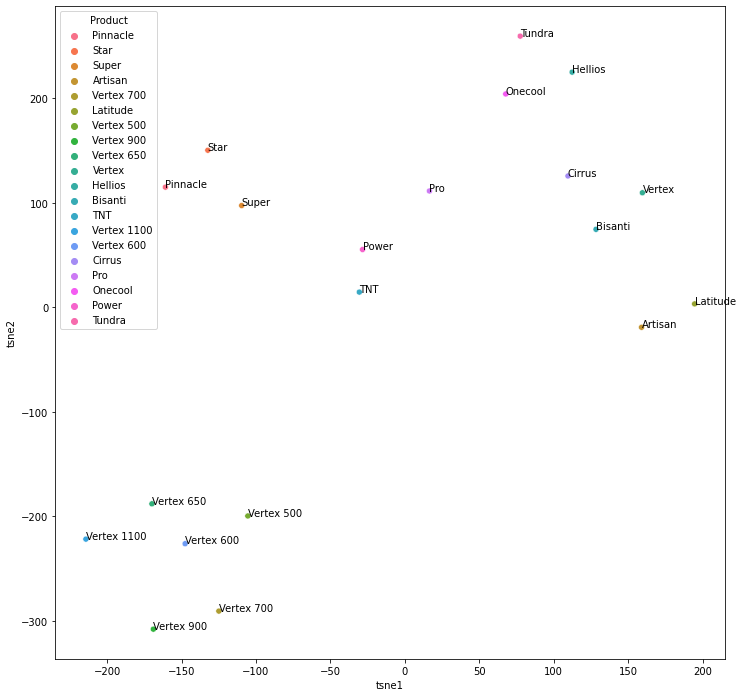

In [ ]:
# tsne
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(word_vectors_list)

# pca 파트
#tsne_results = tsne.fit_transform(PCA(n_components=10).fit_transform(word_vectors_list))

result = pd.DataFrame({'Product': list(vocabs), 'tsne1': tsne_results[:,0], 'tsne2': tsne_results[:,1]})


plt.figure(figsize=(12,12))
ax = sns.scatterplot(x="tsne1", y="tsne2", data=result, hue='Product')
for i, point in result.iterrows():
    ax.text(point['tsne1']+.02, point['tsne2'], str(point['Product']))
plt.show()

In [ ]:
# pca
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(word_vectors_list)
result = pd.DataFrame({'Product': list(glove.dictionary.keys()), 'pca1': printcipalComponents[:,0], 'pca2': printcipalComponents[:,1]})

In [ ]:
pca.explained_variance_ratio_

array([0.52362856, 0.23460426])

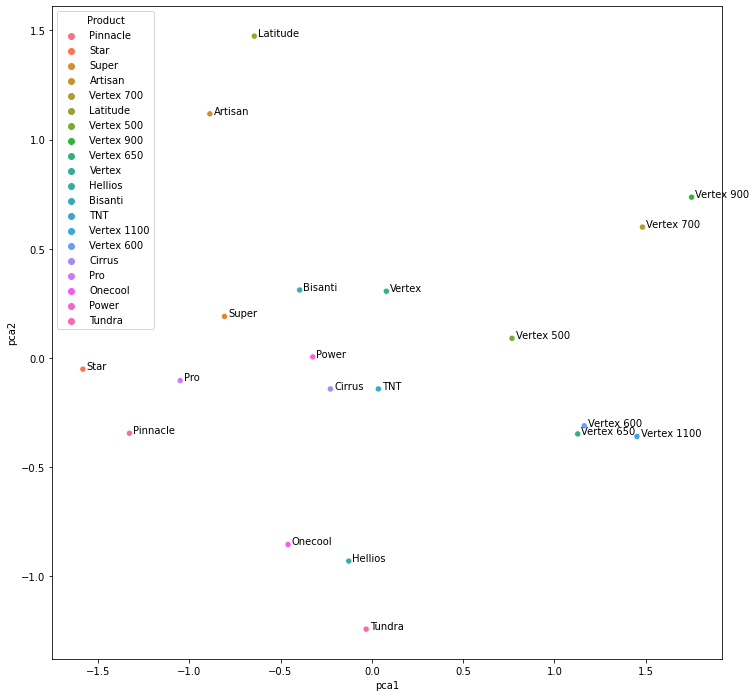

In [ ]:
plt.figure(figsize=(12,12))
ax = sns.scatterplot(x="pca1", y="pca2", data=result, hue='Product')
for i, point in result.iterrows():
    ax.text(point['pca1']+.02, point['pca2'], str(point['Product']))
plt.show()